## This is a FSI problem of a flate plate falling under gravity in quiscent flow

In [1]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
default(grid = false)

In [2]:
using Pkg
Pkg.activate("..")
using FSI

┌ Warning: /home/fs/.julia/packages/Plots/cc8wh/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/fs/.julia/packages/Revise/agmgx/src/Revise.jl:422


In [3]:
filename = "FallingPlate";

## <span style="color:blue"> Set up rigid body with Dyn3d.jl

#### Include any joint-body setup script from Dyn3d

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 6
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
config_body = ConfigBody(nbody, 4,
   [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody

config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dof_1 = Dof(5, "passive", 0., 0., Motions())

config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_y",
    [0.,0.,0.,0.5,3.8,0.], zeros(Float64,6), 0, [dof_1], [0.])

 joint type = custom_prismatic_in_y
 joint position in parent body coord = [0.0, 0.0, 0.0, 0.5, 4.5, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 5, under passive motion
 initial unconstrained dof position = [0.0]
 initial unconstrained dof velocity = [0.0]


#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

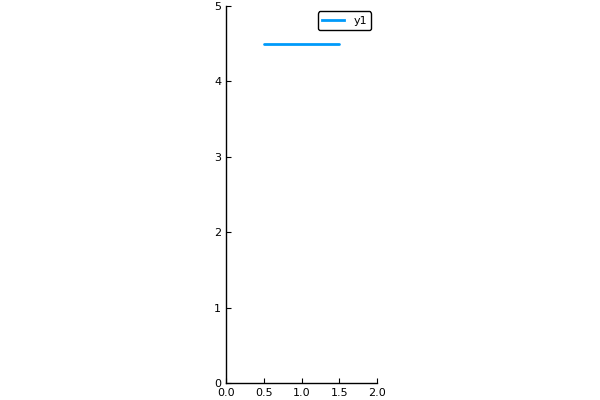

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,2), ylims=(0,4),ratio=1)

## <span style="color:blue"> Set up fluid with ViscousFlow.jl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [11]:
nx = 102; ny = 202;
Ly = 5.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:5.01)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [13]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [14]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [15]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [16]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [17]:
tf = 200Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

#### pretend that this thin body has finite volume for buoyancy

In [18]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=1)

 10.263917 seconds (31.61 M allocations: 1.791 GiB, 9.34% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
thist = []
t = 0.0
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
end

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [21]:
contour_levels = range(-20*Δx,stop=20*Δx,length=40)
sample_rate = 5
clims = (-20*Δx,20*Δx)
fps = 25;

#### Get body verts history

In [22]:
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

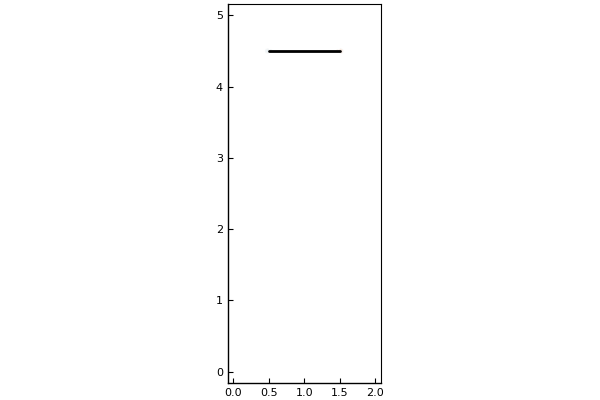

In [23]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_10,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

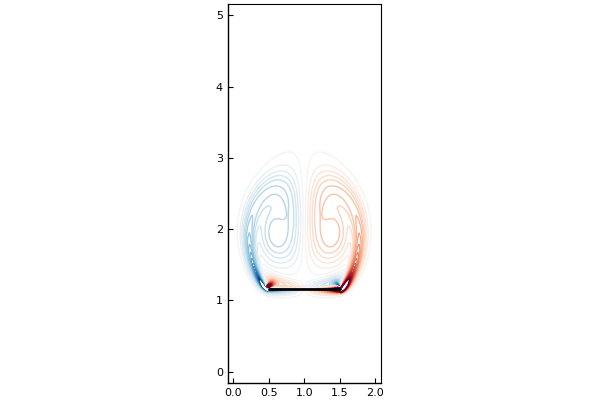

In [24]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_10,clims=clims)

for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

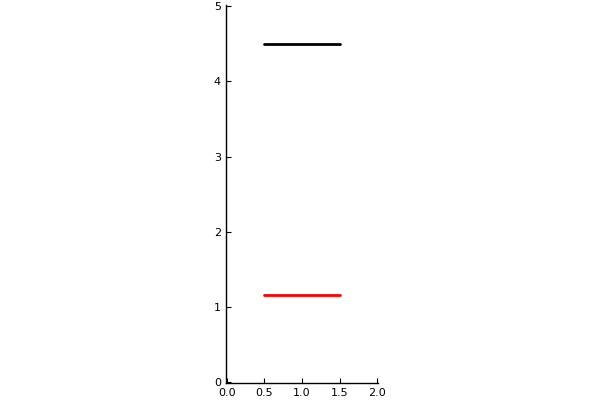

In [25]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1,legend=false)
pb

#### Make gif

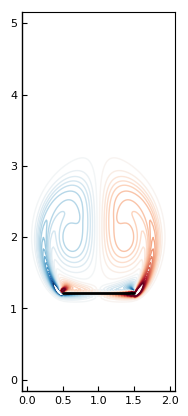

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/thesis/falling_plate/FallingPlate_medium.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/thesis/falling_plate/FallingPlate_medium.gif")

In [26]:
anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_10,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get position, velocity and acceleration in time

In [21]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[5])
    push!(phist,bdhist[i].bs[1].x_i[2]-bdhist[1].bs[1].x_i[2])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

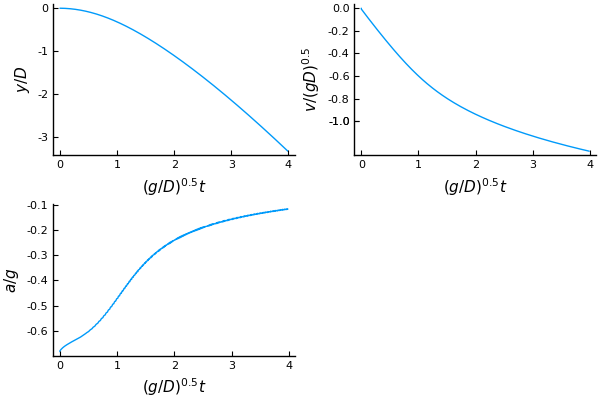

In [22]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false)

plot(pp,pv,pa)

#### Lift and drag coefficients

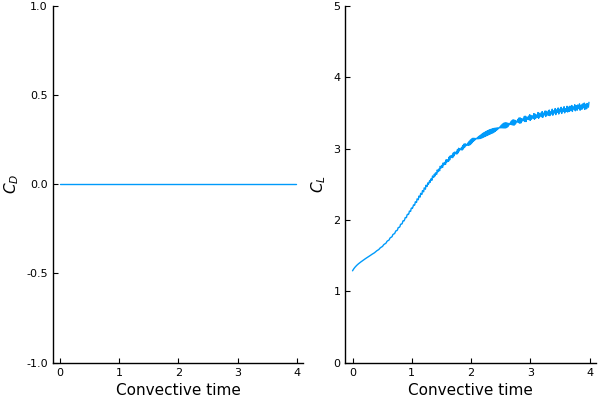

In [31]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [32]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [20]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);